<a href="https://colab.research.google.com/github/yeesem/Deep_Learning/blob/main/Keras_Callbacks_Customization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import datetime
import io

from PIL import Image
from IPython.display import Image as IPyImage
import imageio

In [2]:
# Define the Keras model to add callbacks to
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
    return model

In [3]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

11490434/11490434 [==============================] - 1s 0us/step


In [4]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_train_batch_begin(self, batch, logs=None):
        print('Training: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

    def on_train_batch_end(self, batch, logs=None):
        print('Training: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

In [5]:
model = get_model()
_ = model.fit(x_train, y_train,
          batch_size=64,
          epochs=1,
          steps_per_epoch=5,
          verbose=0,
          callbacks=[MyCustomCallback()])

Training: batch 0 begins at 05:48:08.322174
Training: batch 0 ends at 05:48:08.811036
Training: batch 1 begins at 05:48:08.812755
Training: batch 1 ends at 05:48:08.815369
Training: batch 2 begins at 05:48:08.816430
Training: batch 2 ends at 05:48:08.818496
Training: batch 3 begins at 05:48:08.819477
Training: batch 3 ends at 05:48:08.821606
Training: batch 4 begins at 05:48:08.822543
Training: batch 4 ends at 05:48:08.824530


# Usage of logs dict

In [6]:
callback = tf.keras.callbacks.LambdaCallback(
    on_epoch_end=lambda epoch,logs:
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))
)

model = get_model()
_ = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=64,
          epochs=3,
          verbose=0,
          callbacks=[callback])

Epoch: 0, Val/Train loss ratio: 0.72
Epoch: 1, Val/Train loss ratio: 0.92
Epoch: 2, Val/Train loss ratio: 0.94


# DetectOverfittingCallback

In [24]:
class DetectOverfittingCallback(tf.keras.callbacks.Callback):
  def __init__(self,threshold = 0.9):
    super(DetectOverfittingCallback,self).__init__()
    self.threshold = threshold

  def on_epoch_end(self,epoch,logs = None):
    ratio = logs['val_loss'] / logs['loss']
    print("Epoch: {}, Val/Train loss ratio: {:.2f}".format(epoch, ratio))

    if ratio > self.threshold:
      print("Stopping training...")
      self.model.stop_training = True

model = get_model()
_ = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              batch_size=64,
              epochs=3,
              verbose=0,
              callbacks=[DetectOverfittingCallback()])

Epoch: 0, Val/Train loss ratio: 0.73
Epoch: 1, Val/Train loss ratio: 0.98
Stopping training...


# Custom callback to Visualize predictions

In [9]:
# Load example MNIST data and pre-process it
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

In [18]:
# Visualization utilities
plt.rc('font', size=20)
plt.rc('figure', figsize=(15, 3))

def display_digits(inputs, outputs, ground_truth, epoch, n=10):
    # This line clears the current figure.
    plt.clf()
    # This line removes the y-axis ticks.
    plt.yticks([])
    # This line removes the grid lines.
    plt.grid(None)
    inputs = np.reshape(inputs, [n, 28, 28])
    # Swaps axes 0 and 1 of the inputs array. This is likely done to facilitate displaying multiple images horizontally.
    inputs = np.swapaxes(inputs, 0, 1)
    inputs = np.reshape(inputs, [28, 28*n])
    plt.imshow(inputs)
    # Sets the x-axis ticks at positions [28*x+14 for x in range(n)] with labels given by the outputs array.
    # This likely places the ticks at the center of each image.
    plt.xticks([28*x+14 for x in range(n)], outputs)
    #  Iterates over the x-axis tick labels.
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if outputs[i] == ground_truth[i]:
            t.set_color('green')
        else:
            t.set_color('red')
    plt.grid(None)

In [11]:
GIF_PATH = './animation.gif'

In [22]:
class VisCallback(tf.keras.callbacks.Callback):
    def __init__(self, inputs, ground_truth, display_freq=10, n_samples=10):
        # X
        self.inputs = inputs
        # y
        self.ground_truth = ground_truth
        # List to store images
        self.images = []
        # Number of epochs to show the images
        self.display_freq = display_freq
        # Number of images to display per row
        self.n_samples = n_samples

    def on_epoch_end(self, epoch, logs=None):
        # Randomly sample data
        indexes = np.random.choice(len(self.inputs), size=self.n_samples)
        X_test, y_test = self.inputs[indexes], self.ground_truth[indexes]
        predictions = np.argmax(self.model.predict(X_test), axis=1)

        # Plot the digits
        display_digits(X_test, predictions, y_test, epoch, n=self.n_samples)

        # Save the figure
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = Image.open(buf)
        self.images.append(np.array(image))

        # Display the digits every 'display_freq' number of epochs
        if epoch % self.display_freq == 0:
            plt.show()

    def on_train_end(self, logs=None):
        imageio.mimsave(GIF_PATH, self.images, fps=1)

In [13]:
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='linear', input_dim=784))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

1/1 [==============================] - 0s 95ms/step


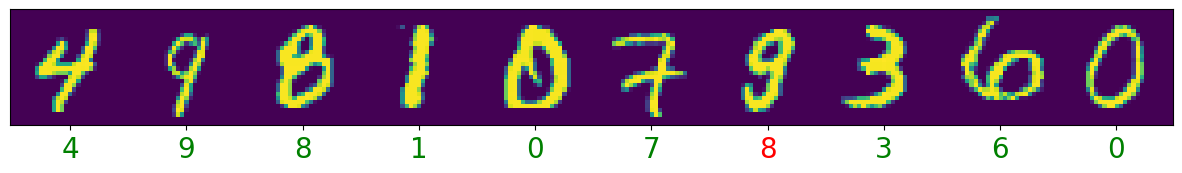

1/1 [==============================] - 0s 20ms/step


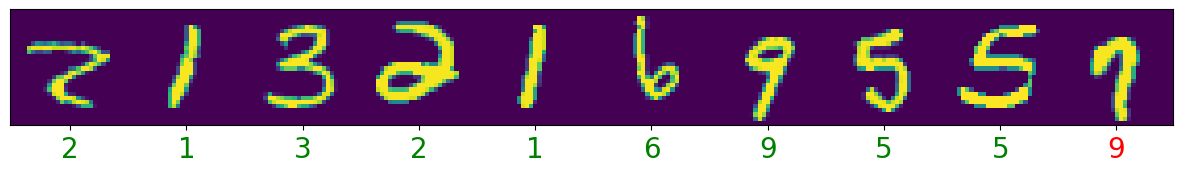

1/1 [==============================] - 0s 20ms/step


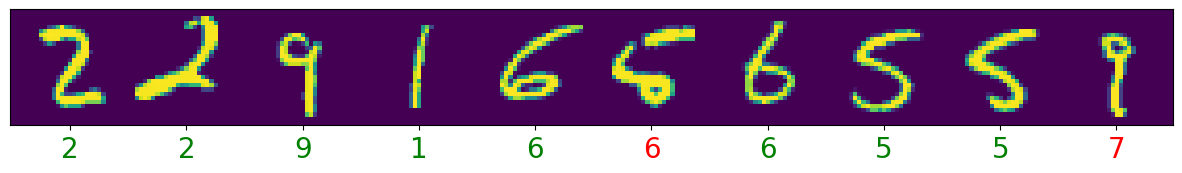

In [23]:
model = get_model()
model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=0,
          callbacks=[VisCallback(x_test, y_test)])

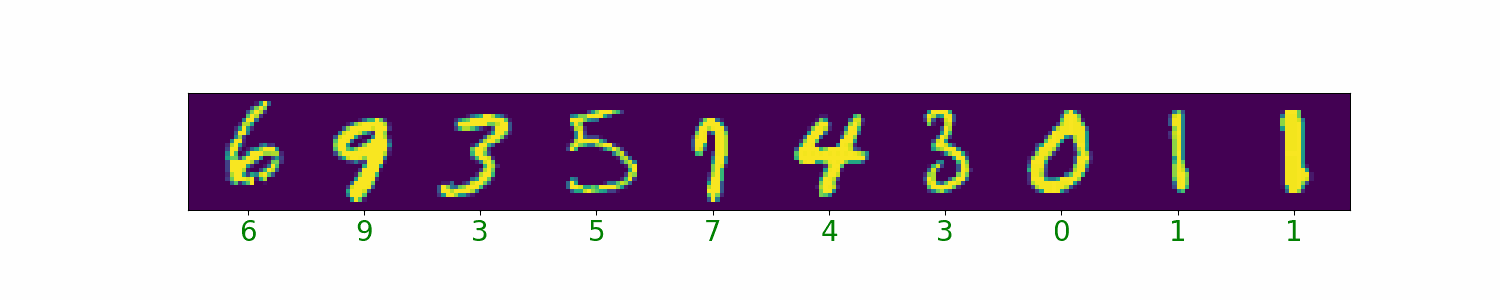

In [15]:
SCALE = 60

# FYI, the format is set to PNG here to bypass checks for acceptable embeddings
IPyImage(GIF_PATH, format='png', width=15 * SCALE, height=3 * SCALE)